In [1]:
import numpy as np
import botorch
import matplotlib.pyplot as plt
from typing import Dict, Optional, Tuple, Union

import torch
from torch import Tensor
torch.set_default_dtype(torch.float64)

from botorch.models import SingleTaskGP
from botorch.models.model import Model
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.acquisition.objective import PosteriorTransform
from botorch.optim import optimize_acqf, optimize_acqf
from botorch.fit import fit_gpytorch_mll
from botorch.utils.transforms import t_batch_mode_transform

from gpytorch.kernels import LinearKernel, PolynomialKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior


_dtype = torch.float64
err_std = 0.01

In [4]:
from construct_machineIO import construct_machineIO
_global_machineIO = construct_machineIO()

In [5]:
class dictClass(dict):
  """ 
  This class is essentially a subclass of dict
  with attribute accessors, one can see which attributes are available
  using the `keys()` method.
  """
  def __dir__(self):
      return self.keys()
    
  def __getattr__(self, name):
    try:
      return self[name]
    except KeyError:
      raise AttributeError(name)
  if dict==None:
    __setattr__ = {}.__setitem__
    __delattr__ = {}.__delitem__
  else:
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

  def __repr__(self):
    if self.keys():
      L = list(self.keys())
      L = [str(L[i]) for i in range(len(L))]
      m = max(map(len, L)) + 1
      f = ''
      for k, v in self.items():
        if isinstance(v,dict):
          f = f + '\n'+str(k).rjust(m) + ': ' + repr(k) + ' class'
        else:
          unitStr=''
          if k in unit:
            unitStr = ' ['+unit[k]+']'
          f = f + '\n'+str(k).rjust(m) + ': ' + repr(v) + unitStr
      return f
    else:
      return self.__class__.__name__ + "()"

  def find_key(self,val):
    if val==None :
      return
    for k in self.keys():
      if self[k]==val:
        return k

In [3]:
def objective_function(x,err_std=err_std):
    return 2*x + 1 + err_std*np.random.randn(), err_std*(1+np.random.randn()*0.1)

In [4]:
class GoalConfidenceBound(AnalyticAcquisitionFunction):
    r"""Single-outcome Goal Confidence Bound (GCB).
    `GCB(x) = -abs(mu(x) - goal) + sqrt(beta) * sigma(x)`, where `mu` and `sigma` are the
    posterior mean and standard deviation, respectively.

    """
    def __init__(
        self,
        model: Model,
        goal: Union[float, Tensor],
        beta: Union[float, Tensor],
        posterior_transform: Optional[PosteriorTransform] = None,
    ) -> None:
        r"""Single-outcome Upper Confidence Bound.

        Args:
            model: A fitted single-outcome GP model (must be in batch mode if candidate sets X will be)
            beta: Either a scalar or a one-dim tensor with `b` elements (batch mode)
                representing the trade-off parameter between mean and covariance
            posterior_transform: A PosteriorTransform. If using a multi-output model,
                a PosteriorTransform that transforms the multi-output posterior into a
                single-output posterior is required.
        """
        super().__init__(model=model, posterior_transform=posterior_transform)
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("goal", torch.as_tensor(goal))

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:
        r"""Evaluate the Upper Confidence Bound on the candidate set X.

        Args:
            X: A `(b1 x ... bk) x 1 x d`-dim batched tensor of `d`-dim design points.

        Returns:
            A `(b1 x ... bk)`-dim tensor of Upper Confidence Bound values at the
            given design points `X`.
        """
        mean, sigma = self._mean_and_sigma(X)
        return -torch.abs(mean - self.goal) + self.beta.sqrt()*sigma

In [5]:
def train_SingleTaskGP(train_X, train_Y, train_Yvar=None, FixedYvar=None, covar_module=None, PolynomialPower=None):
    if PolynomialPower:
        if PolynomialPower == 1:
            covar_module = LinearKernel()
        else:
            covar_module = PolynomialKernel(PolynomialPower)
    else:
        covar_module = covar_module
            
    model = SingleTaskGP(
            train_X, train_Y, train_Yvar=train_Yvar, 
        covar_module=covar_module, 
        input_transform=Normalize(1), 
        outcome_transform=Standardize(1)
    )

    FixedYvar = FixedYvar or 0
    if train_Yvar is None:
        noise = FixedYvar + 1e-6
        noise_var = 0.1*FixedYvar + 1e-6
    else:
        noise = train_Yvar.mean().item() + 1e-6  # noise represent variation of y (output of the evaluator)
        noise_var = train_Yvar.var().item() + 1e-6
    likelihood = GaussianLikelihood(noise_prior=GammaPrior(noise**2/noise_var+1e-12, noise/noise_var+1e-12))
    
    mll = ExactMarginalLogLikelihood(likelihood, model)
    fit_gpytorch_mll(mll,max_attempts=5,pick_best_of_all_attempts=True);

    return model

In [15]:
def SingleInputSingleOutputControl(evaluator,goal,x0,dx,xmin,xmax,PolynomialPower=None,timeout_sec=None):
    y0, y0err = evaluator(x0)
    y1, y1err = evaluator(x0+dx)
    train_X = torch.tensor([[x0],[x0+dx]])
    train_Y = torch.tensor([[y0],[y1]])
    train_Yvar = torch.tensor([[y0err**2],[y1err**2]])
    covar_module = LinearKernel()

    for beta in [4,0]:# [4,1,0]:
        model = train_SingleTaskGP(train_X, train_Y, train_Yvar=train_Yvar, PolynomialPower=PolynomialPower)
        acqu = GoalConfidenceBound(model,goal,beta=beta)
        candidates, acq_value = optimize_acqf(acqu,
                                              bounds=torch.tensor([[xmin],[xmax]]),
                                              q=1, 
                                              num_restarts=8, 
                                              raw_samples=32,
                                              timeout_sec=timeout_sec)
        print(candidates)
        y1, y1err = evaluator(candidates.item())
        train_X = torch.vstack((train_X, candidates))
        train_Y = torch.vstack((train_Y, torch.tensor([[y1]])))
        train_Yvar = torch.vstack((train_Yvar, torch.tensor([[y1err**2]])))

    model = train_SingleTaskGP(train_X, train_Y, train_Yvar=train_Yvar, PolynomialPower=PolynomialPower)

    result = dictClass()
    result.model = model
    result.train_X = train_X
    result.train_Y = train_Y
    result.train_Yvar = train_Yvar
    return result

In [16]:
result = SingleInputSingleOutputControl(objective_function,goal=0,x0=0.5,dx=0.1,xmin=-1,xmax=1.5,PolynomialPower=1)

tensor([[-0.5703]])
tensor([[-0.5063]])


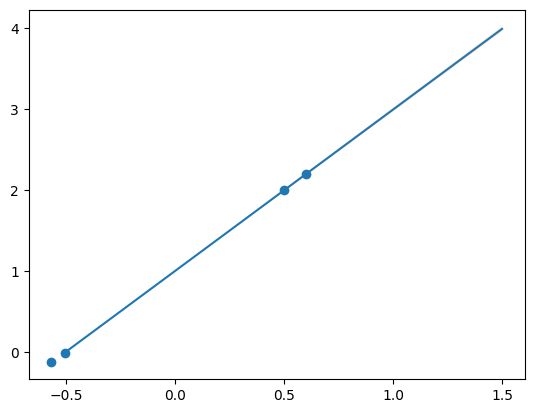

In [17]:
plot_x = torch.linspace(-0.5, 1.5, 100, dtype=_dtype).unsqueeze(-1)
with torch.no_grad():
    posterior = result.model.posterior(plot_x)
    mean, std = posterior.mean, posterior.stddev.view(-1,1)
    lower, upper = mean-2*std, mean+2*std
    
plt.plot(plot_x.view(-1).numpy(), mean.view(-1).numpy(), label='GP Mean')
plt.scatter(result.train_X,result.train_Y)
plt.fill_between(plot_x.view(-1).numpy().flatten(), lower.numpy().flatten(), upper.numpy().flatten(), alpha=0.2, label='GP Confidence Interval')